In [1]:
import os
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def rotate_image(img, origin, angle_radians):
    angle_degrees = np.degrees(angle_radians)
    (h, w) = img.shape[:2]
    center = (origin[0], origin[1])  # x, y

    M = cv2.getRotationMatrix2D(center, angle_degrees, 1)
    rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))

    return rotated

def pad_and_crop_image(img, x1, y1, x2, y2):
    h, w = img.shape[:2]

    # Calculate padding
    pad_left = abs(min(0, int(x1)))
    pad_right = max(0, int(x2) - w)
    pad_top = abs(min(0, int(y1)))
    pad_bottom = max(0, int(y2) - h)

    # Pad the image
    padded_img = cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Update cropping coordinates
    x1_new = x1 + pad_left
    y1_new = y1 + pad_top
    x2_new = x2 + pad_left
    y2_new = y2 + pad_top

    # Crop the image
    cropped_image = padded_img[int(y1_new):int(y2_new), int(x1_new):int(x2_new)]

    return cropped_image

def calculate_average_line(df):
    # Initialize a variable to store the sum of line lengths
    total_length = 0

    # Initialize a variable to count the number of lines
    num_lines = 0

    # Loop through the DataFrame to calculate each line's length
    unique_indices = df['index'].unique()
    for i in unique_indices:
        tmp = df[df['index'] == i]
        ys = tmp['axis-1'].values
        xs = tmp['axis-2'].values

        # Extract the coordinates of the two endpoints
        x1, y1 = xs[0], ys[0]
        x2, y2 = xs[1], ys[1]

        # Calculate the length of the line
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

        # Update the total length and number of lines
        total_length += length
        num_lines += 1

    # Calculate the average line length
    average_length = total_length / num_lines if num_lines > 0 else 0

    return average_length

def stretch_line_using_average_line(x1, y1, x2, y2, average_length):
    # Calculate the center of the line
    x_center = (x1 + x2) / 2
    y_center = (y1 + y2) / 2

    # Calculate the actual length of the line
    actual_length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    # Calculate the unit vector along the line's axis
    dx = (x2 - x1) / actual_length if actual_length != 0 else 0
    dy = (y2 - y1) / actual_length if actual_length != 0 else 0

    # Calculate the new length for each half of the line
    new_half_length = average_length / 2

    # Calculate the new coordinates for the endpoints
    x1_new = x_center - new_half_length * dx
    y1_new = y_center - new_half_length * dy
    x2_new = x_center + new_half_length * dx
    y2_new = y_center + new_half_length * dy

    return x1_new, y1_new, x2_new, y2_new


In [3]:

path_img_dir = '../data/experiment'

target_dir = os.path.join(path_img_dir, 'rotated_and_cropped')
if os.path.exists(target_dir) != True:
    os.mkdir(target_dir)


In [4]:
draw_on_image = False
show_process = False

if os.path.exists(path_img_dir):
    path_imgs = glob.glob(os.path.join(path_img_dir, '*.png'))
    path_imgs = sorted(path_imgs)
    path_df = os.path.join(path_img_dir, 'willemLines.csv')
    df = pd.read_csv(path_df)

    average_length = calculate_average_line(df)
    if show_process == True:
        print('average length =', average_length)

    cropped_images = []
    cropped_images_paths = []

    pbar = tqdm(total = len(path_imgs), position=0, leave=True)
    for i, path_img in enumerate(path_imgs):
        if show_process == True:
            print(i, os.path.basename(path_img))

        img = cv2.imread(path_img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        tmp = df[df['index'] == i]
        if show_process == True:
            print(tmp)

        ys = tmp['axis-1'].values
        xs = tmp['axis-2'].values

        x1, y1 = xs[0], ys[0]
        x2, y2 = xs[1], ys[1]

        # Stretch the line to match the average length
        x1, y1, x2, y2 = stretch_line_using_average_line(x1, y1, x2, y2, average_length)

        ## get center of line
        x_center = (x1 + x2) / 2
        y_center = (y1 + y2) / 2

        ## get radius of line
        radius = np.sqrt((x2 - x1)**2 + (y2 - y1)**2) / 2

        ## calculate crop coordinates
        x1_crop = x_center - radius
        y1_crop = y_center - radius
        x2_crop = x_center + radius
        y2_crop = y_center + radius

        if draw_on_image == True:
            ## draw line on image
            img = cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)

            ## draw center on image
            img = cv2.circle(img, (int(x_center), int(y_center)), 15, (255, 0, 0), -1)

            ## draw cropping rectangle on image
            img = cv2.rectangle(img, (int(x1_crop), int(y1_crop)), (int(x2_crop), int(y2_crop)), (0, 255, 0), 2)

        ## mask image around line with a circle
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        mask = cv2.circle(mask, (int(x_center), int(y_center)), int(radius), (255, 255, 255), -1)
        img = cv2.bitwise_and(img, img, mask=mask)

        angle = np.arctan2(y2 - y1, x2 - x1)

        img_rotated = rotate_image(img, (x_center, y_center), angle)

        if show_process == True:
            print("Image shape:", img_rotated.shape)
            print("Cropping coordinates:", x1_crop, y1_crop, x2_crop, y2_crop)

        img_cropped = pad_and_crop_image(img_rotated, x1_crop, y1_crop, x2_crop, y2_crop)
        cropped_images.append(img_cropped)

        if show_process == True:
            print('cropped image shape =', img_cropped.shape)

        path_img_cropped = os.path.join(target_dir, os.path.basename(path_img))
        cropped_images_paths.append(path_img_cropped)

        if show_process == True:
            fig, ax = plt.subplots(1, 3)

            ax[0].imshow(img)

            ax[1].imshow(img_rotated)

            ax[2].imshow(img_cropped)

            plt.show(fig)
            plt.close(fig)

        pbar.update(n=1)
    pbar.close()

    cropped_image_shapes = [img.shape[:2] for img in cropped_images]

    # Calculate the average shape
    average_shape = np.mean(np.array(cropped_image_shapes), axis=0).astype('int')

    # Resize the images to the average shape
    cropped_images_resized = [cv2.resize(img, (average_shape[1], average_shape[0])) for img in cropped_images]

    for path_cropped_image, cropped_img in zip(cropped_images_paths, cropped_images):
        cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(path_cropped_image, cropped_img)


100%|██████████| 78/78 [00:10<00:00,  7.28it/s]


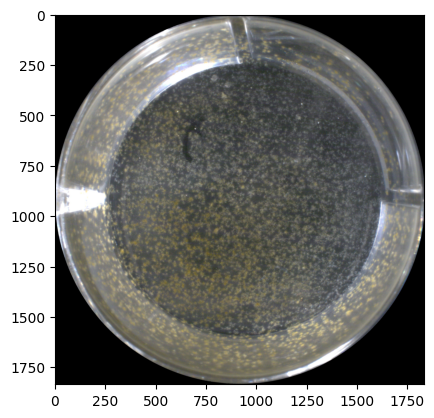

In [5]:
cropped_img = cropped_images[0]
plt.imshow(cropped_img)

In [10]:

groups = []
dates = []
for path_cropped_image in cropped_images_paths:
    name = os.path.basename(path_cropped_image)
    date = name.split('__')[1]
    group = name.split('__')[2]
    ## make group uppercase
    group = group.upper()
    dates.append(date)
    groups.append(group)

df = pd.DataFrame(list(zip(path_cropped_image, groups, dates, cropped_images)),
    columns=['path', 'group', 'date', 'image'])


In [21]:
def get_group_type_key (group):
    key = group[0]
    if key == 'G':
        key = 0
    elif key == 'U':
        key = 1
    else:
        key = 3
    return key

def get_group_number (group):
    num = int(group[1:])
    return num

def get_date_num(date):
    num = date.split('_')[1]
    return int(num)


unq_groups = df['group'].unique()
unq_groups = sorted(unq_groups, key=get_group_number)
unq_groups = sorted(unq_groups, key=get_group_type_key)
unq_dates = df['date'].unique()
unq_dates = sorted(unq_dates, key=get_date_num)

print(unq_groups)
print(unq_dates)

['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16', 'G17', 'G18', 'U1', 'U2', 'U3', 'U4', 'U5', 'U6']
['5_6_2023', '5_9_2023', '5_12_2023', '5_15_2023']


In [22]:
n_unq_groups = len(unq_groups)
print(n_unq_groups)

ncols = 6
nrows = 4

print(nrows*ncols==n_unq_groups)

24
True


In [ ]:
figure_dir = os.path.join(path_img_dir, 'small_multiples_plots')
if os.path.exists(figure_dir) != True:
    os.mkdir(figure_dir)

for unq_date in unq_dates:
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, 18))

    pbar = tqdm(total = n_unq_groups, position=0, leave=True)
    for i, unq_group in enumerate(unq_groups):

        ax = axs[i//ncols, i%ncols]
        tmp = df[(df['date'] == unq_date) & (df['group'] == unq_group)]

        if tmp.shape[0] > 0:
            img = tmp['image'].values[0]
            ax.imshow(img)
            text = unq_group
            ## add group number as text to upper left of image
            ax.text(0, 0, text, color='white', fontsize=20, fontweight='bold', va='top', ha='left')
            ax.axis('off')
        else:
            ax.axis('off')

        pbar.update(n=1)
    pbar.close()

    fig.tight_layout()

    path_fig = os.path.join(figure_dir, unq_date + '.png')
    plt.savefig(path_fig, dpi=300, bbox_inches='tight')

    plt.show(fig)
    plt.close()


100%|██████████| 24/24 [00:00<00:00, 182.03it/s]
